In [ ]:
from time import time
import numpy as np
import copy as cp
import pylab as plb
%pylab inline

from scipy.integrate import odeint 
from numpy.random import permutation

from sklearn.decomposition import MiniBatchDictionaryLearning
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn import linear_model


Populating the interactive namespace from numpy and matplotlib


In [ ]:
#random variation of parameters
def randpar(par,var):
    '''This function adds gaussian noise to parameters stored in a dictionary. 
    var is the std of the gaussian distribution (1 = 100% of the not noisy value).'''
    flag = 0
    while flag == 0:
        temp = cp.deepcopy(par)
        for key in par.keys():
            temp[key]=par[key]*(1+var*plb.randn())
            #if temp[key] < 0:
            #    flag = 0
            #    break
            #else:
                #flag =1
            if temp[key] < 0:
                temp[key] = 0
        flag = 1            
    return temp  

# 1D Day Model

In [ ]:
# Mp model by Reynolds et al
def MPder(y,t,p):  # return derivatives of the array y in MP model (reduced Reynolds) 

    der = np.array([p['sm']-p['mm']*y[0]-p['kmp']*y[0]*y[1],\
                    -p['kpm']*p['sm']*y[1]/(p['mm']+p['kmp']*y[1])\
                    +p['kpg']*y[1]*(1-y[1]/p['pinf'])])
    return der

MPpar= dict(kpg  = 0.6,kpm  = 0.6,kmp  = 0.01,kpn  = 1.8,knn  = 0.01,\
      knp  = 0.1,kdn  = 0.35,kcn  = 0.04,kcnd = 48.0,knd  = 0.02,\
      sm   = 0.005,snr  = 0.08,sc   = 0.0125,mm   = 0.002,mnr  = 0.12\
      ,mn   = 0.05,md   = 0.02,mc   = 0.1,xdn  = 0.06,pinf = 20.0,\
      cinf = 0.28)

In [ ]:
def HOder(y,t,p):
    
    der = np.array([0*y[0]+1/p['m']*y[1],-p['k']*y[0]])
    return der

HOpar = dict(m=2,k=1)

# Function to return trajectories

In [ ]:
# for fixed Delta t solve 300 trajectories
def traj_solve(N,dt,mod,mod_par,var):
    t0 = 0
    tend = 100
    Nt = (tend-t0)/float(dt)
    time = np.linspace(t0,tend,Nt)
    
    traj = np.full((N,len(time),2),-3.)
    for i in range(N):
        # add noise to the position of the fixed point
        rlvpar = randpar(mod_par,var)
        # sample randomly from both basins of attraction
        if mod != 'HOder':
            if plb.rand() > 0.5:
                yinit = 0.3 + plb.rand(2)*2
            else:
                yinit = plb.rand(2)*0.3
        else:
            yinit = plb.rand(2)*array([3,0])
            
        traj[i,:,:] = odeint(mod,yinit,time,args = (rlvpar,))
    return traj,time    

## Example

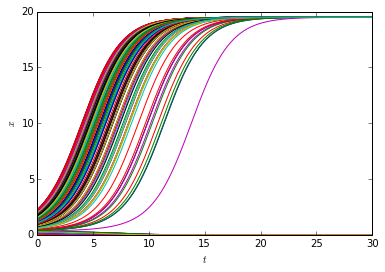

In [ ]:
N=300
traj,time = traj_solve(N,0.1,MPder,MPpar,0.0)

for i in range(N):
    plot(time[:],traj[i,:,1])
    xlabel("$t$")
    ylabel("$x$")
    xlim((0,30))
    ylim((0,20))

In [ ]:
N= 10
traj,time = traj_solve(N,0.1,HOder,HOpar,0.0)

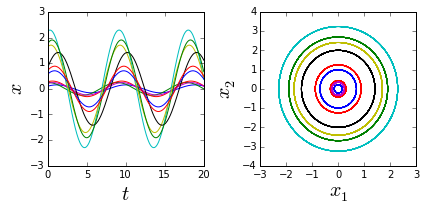

In [ ]:
figure(figsize=(6,3))
for i in range(N):
    subplot(1,2,1)
    plot(time[:],traj[i,:,0])
    xlabel("$t$",size = 20)
    ylabel("$x$",size =20)
    xlim((0,20))
    ylim((-3,3))
    subplot(1,2,2)
    plot(traj[i,:,0],traj[i,:,1])
    xlabel("$x_1$",size = 20)
    ylabel("$x_2$",size =20)
    xlim((-3,3))
    ylim((-4,4))
tight_layout()  
savefig("HO_example.pdf",transparent = True)

# trajectories to samples of f

In [ ]:
def traj_der(traj,time):
    N,Nt,Nvar = np.shape(traj)
    dt = time[1]- time[0]
    trajder = np.full((N,Nt-1,Nvar),-3.)
    for i in range(N):
        for j in range(Nt-1):
            for k in range(Nvar):
                trajder[i,j,k] = (traj[i,j+1,k]-traj[i,j,k])/dt
                
    return trajder            

## Example

In [ ]:
trajder = traj_der(traj,time)
for i in range(N):
    plot(traj[i,:-1,1],trajder[i,:,1],'o')
    xlabel("$x$")
    ylabel("$f(x)$")
    xlim((0,20))
    ylim((-0.05,4))

NameError: name 'traj_der' is not defined

# Scale and discretize measurments to fit on a 256x1 grid

In [ ]:
#convert discrete index to x position in the model

#255 -> 20
#127 -> 0.6
def ind_to_x(i):
    if i < 128:
        return i/127*0.6
    else:
        return (19.5 - 0.6)/128*i +0.6-127*18.9/128

In [ ]:
# convert x position to discrete index

#20 -> 256
#0.6 -> 127
def x_to_ind(x):
    ind = 0
    if x < 0.6:
        ind = round(x /0.6*127)
    else:
        ind = round((x-0.6+127/128*18.9)/(18.9/128))
    return int(ind)    

In [ ]:
ind_to_x(255)

19.500000000000004

In [ ]:
def traj_to_f_meas(traj,trajder):
    N,Nt,Nvar = np.shape(traj)
    f_meas = np.full((N,256),-100.)
    for k in range(N):
        for i in range(Nt-1):
            #make sure index fits into the 256 array
            if x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.) < 256:
                f_meas[k,x_to_ind((traj[k,i+1,1]+traj[k,i,1])/2.)] = trajder[k,i,1]
    return f_meas        

In [ ]:
f_meas = traj_to_f_meas(traj,trajder)
for i in range(10):
    plot(range(256),f_meas[i,:],'o')
ylim((-.05,3))
xlim((-1,256))

NameError: name 'traj' is not defined

# Sparsely reconstruct under-sampled data in basis

In [ ]:
def patch_rec(data,basis,nmeas,ps1,ps2,real_data = False):
    clf = linear_model.Lasso(alpha=0.000004, copy_X=True, fit_intercept=False, max_iter=3000, tol=0.00000000001)

    #create array for reconstructed data
    recdata = np.full(data.shape,0.)

    #mean normalize data
#    intercept = np.mean(data, axis=0)
#    data -= intercept

    #for each patch:
    #(1) downsample data and down sample basis
    #(2) find sparse representation
    #(3) reconstruct patch from sparese representation and original basis
    for i in range(len(data[:,0])):
        #(1) and (2)
        # generate list of random, unique samples
        if real_data == False:
            rm = sorted(permutation(ps1*ps2)[:nmeas])
        else:
            rm = [j for j in range(ps1*ps2) if data[i,j]!=-100.]
            if rm == []:
                #print("not enough data!\n")
                #print(i)
                continue
        clf.fit(basis[:,rm].T, data[i,rm])
        #(3) reconstruct patch from fit coefficients
        recdata[i,:] = np.dot(basis.T,clf.coef_)
    
    #add mean normalization back
#    recdata += intercept
#    data += intercept
    return recdata

In [ ]:
def image_rec(original,basis,nmeas,ps1,ps2,real_data = False):
    patch_size = (ps1,ps2)
    imsize = original.shape
    #take one function and turn to patches
    data = extract_patches_2d(original, patch_size)
    data = data.reshape(data.shape[0], -1)
    
    datarec = patch_rec(data,basis,nmeas,ps1,ps2,real_data= real_data)
    #turn datarec into image
    datarec = datarec.reshape(len(datarec), *patch_size)
    rec = reconstruct_from_patches_2d(datarec, imsize)
    return rec

# learn basis from data

In [ ]:
#number of trajectories to include
def f_prep(N,NTraj,f_meas,b_size):
    #start with a random basis
    r_basis = np.random.rand(100,b_size)

    #sample randomly from all trajectories
    s = sorted(permutation(N)[:NTraj])
    f_m = np.full((1,256),-100.)
    #average over each column and only those values that are not -100.
    for i in range(256):
        col = [f_meas[k,i] for k in s if f_meas[k,i]!= -100.]
        if col == []:
            f_m[0,i] = -100.
        else:
            f_m[0,i] = np.mean(col)
    return f_m,r_basis

In [ ]:
# learn basis, return reconstruction and basis
def basis_and_rec(f_m,init_basis):
    b_size = init_basis.shape[1]
    #print(b_size)
    #reconstruct sparsely in random basis
    #rec = image_rec(f_m,init_basis,1,1,b_size,real_data = True)
    i1,i2=f_m.shape
    rec0 = np.random.rand(i1,i2)
    rec0[f_m !=-100.] = f_m[f_m !=-100.]
    tempdic = MiniBatchDictionaryLearning(n_components=30, alpha=1., n_iter=10000 )
    # resize to basis size
    datarec = extract_patches_2d(rec0, (1,b_size))
    datarec = datarec.reshape(datarec.shape[0], -1)

    V = tempdic.fit(datarec).components_
    rec = image_rec(f_m,V,1,1,b_size,real_data = True)
    
    return V,rec,rec0

# measure Error

In [ ]:
def norm_1(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)
    if np.linalg.norm(r)!=0.:
        norm = 1. - abs(np.dot(d,r))/np.linalg.norm(d)/np.linalg.norm(r)
    else:
        norm = 1. 
    return norm

def norm_2(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)
    return norm

def norm_3(original,reconstructed):
    # reshape input to one dimensional arrays
    d = np.reshape(original,-1)
    r = np.reshape(reconstructed,-1)

    norm = np.linalg.norm(d-r)/np.linalg.norm(d)
    return norm

# Running Script

In [ ]:
#create reference function f_ref
f_ref = np.full((1,256),0.)
for i in range(256):
    f_ref[0,i] = MPder([i,ind_to_x(i)],1,MPpar)[1]
Nave = 1

dt_list = [5]#[0.1,0.2,0.5,1,2,5]
Ntraj_list = [10]#[1,2,5,10,15,20,50,100]
b_size_list = [50]#[10,20,50,100,120,150,180,200]
b_size = b_size_list[0]
res = np.full((len(dt_list)*len(Ntraj_list)*len(b_size_list),6),0.) 

k = -1
for dt in dt_list:#:
    # generate trajectories
    traj,time = traj_solve(300,dt,MPder,MPpar,0.0)
    #generate derivatives
    trajder = traj_der(traj,time)
    #rescale to sample f
    f_meas = traj_to_f_meas(traj,trajder)


    #sample NTraj trajectories
    for Ntraj in Ntraj_list:
        print('dt = '+str(dt))
        print('Ntraj = '+str(Ntraj))
        t_rec = np.full((Nave,3),0.)
        k+=1
        for i in range(Nave):
            f_m,r_basis = f_prep(300,Ntraj,f_meas,b_size)
            # learn basis and reconstruct
            V,rec,rec0 = basis_and_rec(f_m,r_basis)
            t_rec[i]=[norm_1(f_ref,rec),norm_2(f_ref,rec),norm_3(f_ref,rec)]

        res[k,:3] = [dt,Ntraj,b_size]
        res[k,3:]= np.mean(t_rec,0)

//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/least_angle.py:170: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif Gram == 'auto':
//anaconda/envs/py3/lib/python3.4/site-packages/sklearn/linear_model/coordinate_descent.py:444: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations
  ConvergenceWarning)


dt = 5
Ntraj = 10


(-0.1, 3.6)

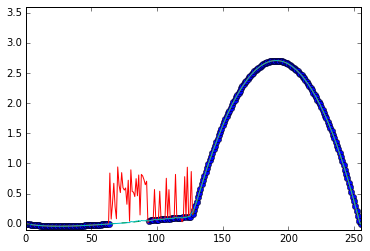

In [ ]:
plot(f_m[0],'o')
plot(f_ref[0],'--')
plot(rec0[0],'-')
plot(rec[0],'-')
xlim(0,255)
ylim(-0.1,3.6)

In [ ]:
plot(f_m[0])

NameError: name 'f_m' is not defined

In [ ]:
datarec = extract_patches_2d(rec0, (1,b_size))
datarec = datarec.reshape(datarec.shape[0], -1)

In [ ]:
datarec.shape

(207, 50)

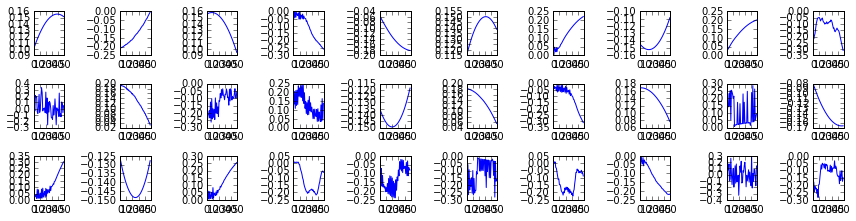

In [ ]:
figure(figsize = (12,10))
for i,comp in enumerate(V):
    subplot(10,10,1+i)
    plot(comp[:])
    
tight_layout()    

In [ ]:
#np.savetxt("1d_example_rec_b.txt",rec)
#Ntraj = 10, dt = 5, b_size = 50
#error = 0.011180449347806598

#np.savetxt("1d_example_rec_g.txt",rec)
#Ntraj = 50, dt = 0.1, b_size = 50
# error = 2.2190548538914001e-05

In [ ]:
norm_1(f_ref[0],rec_b)

0.011180449347806598

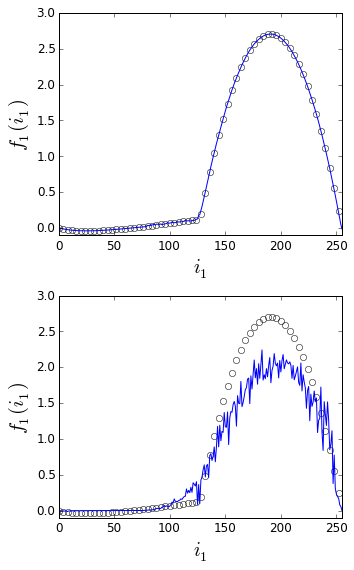

In [ ]:
rec_b = np.loadtxt("1d_example_rec_b.txt")
rec_g = np.loadtxt("1d_example_rec_g.txt")
f_ref = np.full((1,256),0.)
for i in range(256):
    f_ref[0,i] = MPder([i,ind_to_x(i)],1,MPpar)[1]
figure(figsize=(5,8))
subplot(2,1,1)
plot(range(256)[::4],f_ref[0][::4],'go',label = 'original',mfc='None')
plot(rec_g,'b',label="reconstruction")
#legend()
xlabel('$i_1$',size = '20')
ylabel('$f_1(i_1)$',size = '20')
xlim(0,255)
ylim(-0.1,3)
tick_params(axis='both', which='major', labelsize=12) 
#tight_layout()
#savefig("1d_example_rec_g.pdf")
subplot(2,1,2)
plot(range(256)[::4],f_ref[0][::4],'go',label = 'original',mfc='None')
plot(rec_b,'b',label="reconstruction")
#legend()
xlabel('$i_1$',size = '20')
ylabel('$f_1(i_1)$',size = '20')
xlim(0,255)
ylim(-0.1,3)
tick_params(axis='both', which='major', labelsize=12) 
tight_layout()
savefig("ofd/1d_example_rec_gb.pdf")

In [ ]:
rec_g = np.loadtxt("1d_example_rec_g.txt")

plot(rec_g,label="reconstruction")
plot(f_ref[0],'--',label = 'original')
legend()
xlabel('$x$',size = '20')
ylabel('$f(x)$',size = '20')
xlim(0,255)
ylim(-0.1,3.6)
tight_layout()
savefig("1d_example_rec_g.pdf")

NameError: name 'np' is not defined

In [ ]:
norm_1(f_ref[0],rec_g)

2.2190548538914001e-05

# Turn reconstruction into models

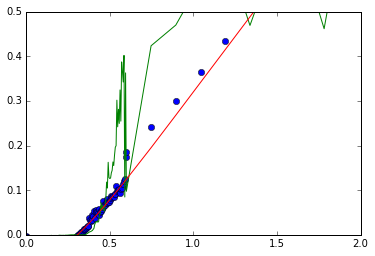

In [ ]:
import matplotlib.pyplot as plt
from scipy import interpolate
x = np.arange(0, 256)
xnew = array([ind_to_x(i) for i in x])
# good and bad reconstruction values
y_g = rec_g
y_b = rec_b
#create functions to be called as derivatives
f_g = interpolate.interp1d(xnew, y_g,kind='linear',bounds_error=False,fill_value=0.0)
f_b = interpolate.interp1d(xnew, y_b,kind='linear',bounds_error=False,fill_value=0.0)


plt.plot(xnew, rec_g,'o')
plt.plot(xnew, rec_b)
plt.plot(xnew, f_ref[0])
xlim(0,2)
ylim(0,0.5)
plt.show()

In [ ]:
def f_good(x,t):
    if x> 0. and x < max(xnew):
        return f_g(x)
    else:
        return 0.

def f_bad(x,t):
    if x> 0. and x < max(xnew):
        return f_b(x)
    else:
        return 0.    

# Function to solve trajectories from reconstructed models

In [ ]:
dt = 0.1
t0 = 0
tend = 100
Nt = (tend-t0)/float(dt)
time = np.linspace(t0,tend,Nt)
init_list = [0.1,0.2, 0.3, 1, 2., 5., 10.]
N = len(init_list)
traj_g = np.full((len(init_list),len(time)),-3.)
traj_b = np.full((len(init_list),len(time)),-3.)
traj = np.full((len(init_list),len(time),2),-3.)
for i,k in enumerate(init_list):
    # sample randomly from both basins of attraction
    yinit = array([1,1])*k
    traj_g[i,:] = odeint(func = f_good,y0 = yinit[1],t=time)[:,0]
    traj_b[i,:] = odeint(func = f_bad,y0 = yinit[1],t=time)[:,0]
    traj[i,:,:] = odeint(MPder,yinit,time,args = (MPpar,))


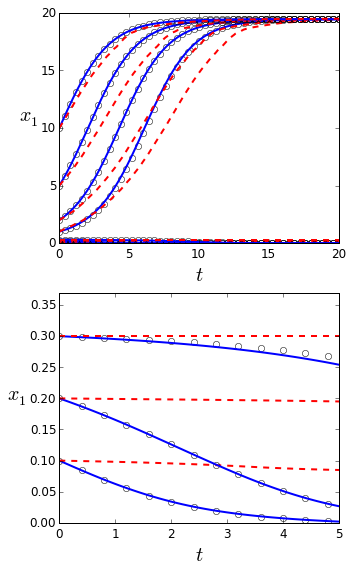

In [ ]:
figure(figsize=(5,8))
for i in range(N):
    subplot(2,1,1)
    plot(time[::4],traj[i,::4,1],'go',label='Original',mfc = 'None')
    plot(time,traj_g[i,:],'b-',label="Good Rec",linewidth=2.0)
    plot(time,traj_b[i,:],'r--',label="Poor Rec",linewidth=2.0)
    #if i ==0:
        #legend(loc=4)
    xlim(0,20) 
    ylim(0,20)
    xlabel("$t$",size='20')
    ylabel("$x_1$   ",size='20',rotation=0)
    tick_params(axis='both', which='major', labelsize=12) 
    subplot(2,1,2)
    plot(time[::4],traj[i,::4,1],'go',label='Original',mfc = 'None')
    plot(time,traj_g[i,:],'b-',label="Good Rec",linewidth=2.0)
    plot(time,traj_b[i,:],'r--',label="Poor Rec",linewidth=2.0)
    #if i ==0:
        #legend()
    ylim(0,0.37)
    xlim(0,5)
    xlabel("$t$",size='20')
    ylabel("$x_1$   ",size='20',rotation=0)
tick_params(axis='both', which='major', labelsize=12)     
tight_layout()    
#savefig("ofd/1d_traj_rec_gb_original.pdf")